# Machine Learning Model's Development
#### The first step, dealing with data extraction, consolidating a dataset with target labeling and feature engineering was documented on the previous notebook: `01_data_preparation.ipynb`

##Presence of null values

As we concluded at the end of the previous dataset, the null values present on our dataset are not missing values, instead, they are information itselves: a missing value on date of the second order is totally justified, since the number of orders of that client was one, etc.

## Importing Libraries
Considering what is above said, we will prioritaze using Machine Learning Algorithms that handle well the presence of Null values, such as: XGBoost, Random Forest, Decision Tree. If we fail to achieve a good performance on these algorithms, then we will consider another data transformations, in order to use algorithms that are intolerant to data treatment.

In [ ]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

## Importing data

In [3]:
df = pd.read_csv('clients_info.csv')

In [4]:
df.head()

,number_of_orders,recency,total_spent,average_ticket,gender,age,t_12,t_23,t_34,churn,...,order_1_day_of_month,order_2_year,order_2_month,order_2_day_of_month,order_3_year,order_3_month,order_3_day_of_month,order_4_year,order_4_month,order_4_day_of_month
0,1,851,77.000000,77.000000,1,57,NaN,NaN,NaN,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1382,148.000000,148.000000,1,18,NaN,NaN,NaN,1,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1617,129.480000,129.480000,0,56,NaN,NaN,NaN,1,...,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,5,173.000000,86.500000,0,66,44.0,NaN,NaN,0,...,15,2025.0,6.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,970,105.949997,105.949997,1,38,NaN,NaN,NaN,1,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80099 entries, 0 to 80098
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_of_orders      80099 non-null  int64  
 1   recency               80099 non-null  int64  
 2   total_spent           80099 non-null  float64
 3   average_ticket        80099 non-null  float64
 4   gender                80099 non-null  int64  
 5   age                   80099 non-null  int64  
 6   t_12                  29417 non-null  float64
 7   t_23                  9675 non-null   float64
 8   t_34                  4791 non-null   float64
 9   churn                 80099 non-null  int64  
 10  order_1_year          80099 non-null  int64  
 11  order_1_month         80099 non-null  int64  
 12  order_1_day_of_month  80099 non-null  int64  
 13  order_2_year          29417 non-null  float64
 14  order_2_month         29417 non-null  float64
 15  order_2_day_of_mont

## Verifying balance on the target (churn) variable

In [6]:
df['churn'].value_counts(normalize = True)

,proportion
churn,
1,0.602854
0,0.397146


The ideal scenario here is a 50-50% balance. However, 60-40 is still acceptable. For it do not become a bias problem in our model's training process, we will guarantee to make a stratified target train-test dataset split.

In [7]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 99)

## XGBoost
In our first trying on finding the best algorithm to our prediction model, we will use XGBoostClassifier, which is a powerful and robust algorythm considering our classification problem, and see how it performs.

In [9]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
y_pred = model.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6362
           1       1.00      1.00      1.00      9658

    accuracy                           1.00     16020
   macro avg       1.00      1.00      1.00     16020
weighted avg       1.00      1.00      1.00     16020



### Having 100% on all metrics is usually suspicious and not normal. In real-world scenarios, it’s a critical red flag, as it may indicate:

- **Target leakage**: One of the features in `X` might be directly related to churn.  
  *Example:* `t_12`, `t_23`, `t_34`, or date columns that indirectly indicate churn.

- **Duplicate data between train and test**: Ther might have some data leakage between `X_train` and `X_test`.

- **Columns with NaNs used as signals**: The model might be using the presence of `NaN` (e.g., `t_34 == NaN`) as a perfect proxy for churn.

- **Model complexity**: XGBoost is extremely powerful and can easily overfit when some features are highly indicative.

To investigate it's causes, we're going to:



*   Verify columns that are highly correlated with the target (churn). The goal is **catch if any have a correlation value close to 1**.

*   Make a Feature Importance chart, in order to see if any date or days interval column is on the roll of most importants features, **which could configure in Data Leakage**.

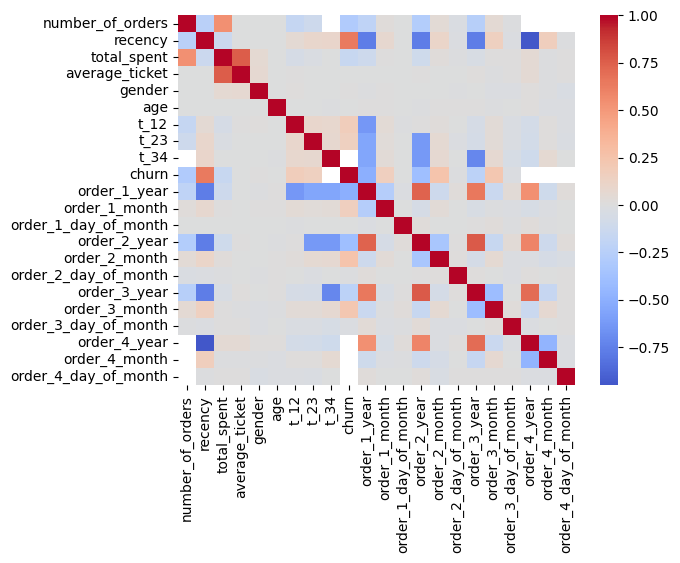

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.show()

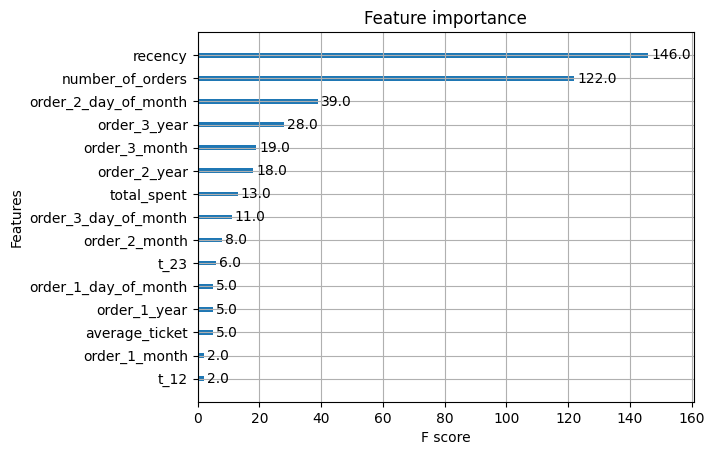

In [13]:
from xgboost import plot_importance
plot_importance(model, max_num_features=15)
plt.show()

## Decision: remove features that might induce Target Leakage
One of the most crucial steps in this project was defining what "churn" actually means.

After exploratory analysis, I discovered strong behavioral patterns based on the number of purchases a client made. This led to a **stage-based churn definition**:

- Clients with 1 purchase → churn if recency > median time between 1st and 2nd purchase.
- Clients with 2 purchases → churn if recency > median time between 2nd and 3rd purchase.
- Clients with 3 purchases → churn if recency > median time between 3rd and 4th purchase.
- Clients with 4 purchases → churn if recency > harmonic mean of the 3 intervals above.

To operationalize this logic, I created the following variables:

- `recency` → Days since last purchase  
- `t_12`, `t_23`, `t_34` → Time between sequential orders  
- `order_n_year`, `order_n_month`, `order_n_day_of_month` → Decomposed date parts  

These features were essential to **calculate the behavioral thresholds that define churn**

With this given, I will run a test **removing** `t_12`, `t_23`, `t_34`, the date-related columns `order_X_*`, and the `recency` column — since these were the criteria I used to define churn during data preparation (`01_data_preparation.ipynb`).

They contain information that directly determines the target and might be unfairly inflating the model's performance.

Hopefully, this will lead to more realistic results.

In [14]:
X_simplified_v2 = df.drop([
    'churn',
    'recency',
    't_12', 't_23', 't_34',
    'order_2_year', 'order_2_month', 'order_2_day_of_month',
    'order_3_year', 'order_3_month', 'order_3_day_of_month',
    'order_4_year', 'order_4_month', 'order_4_day_of_month'
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_simplified_v2, y, test_size=0.2, stratify=y, random_state=99)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      6362
           1       0.93      0.97      0.95      9658

    accuracy                           0.94     16020
   macro avg       0.94      0.93      0.93     16020
weighted avg       0.94      0.94      0.93     16020



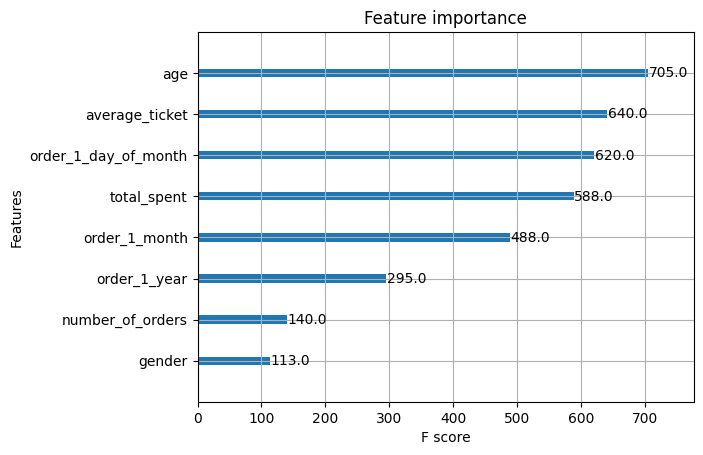

In [15]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)
plt.show()

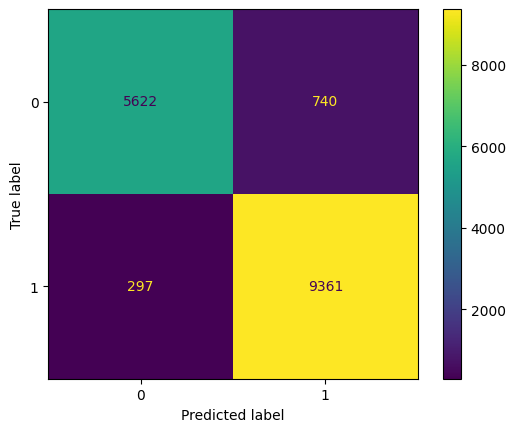

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## ✅ Success Outcome! - Found and removed Target Leakage

After removing the leakage features:

- The model performance dropped from perfect (unrealistic) to **~94% accuracy**, with balanced precision and recall.
- This is a **much healthier, more trustworthy model** that can actually help drive business decisions.


### As I previously assumed:

Using these same features to train the machine learning model introduced **target leakage** — meaning, the model would have access to information that was **used to define the target variable itself**.

This would artificially inflate model performance (e.g., 100% accuracy), but with no real-world value or generalization capacity.

To ensure that the model learns patterns based only on **independent behavioral or demographic data**, we removed these leakage-prone variables from the feature set.

> Although the model uses a relatively small set of features, all of them are clean, reliable, and available in real time — and the performance remains high (~94% accuracy). Future versions of this model could benefit from additional behavioral or transactional variables to further refine churn detection.


## **Summary:**  
> Features like `recency`, `t_12`, `t_23`, and date parts were used to define churn — not to predict it.  
> To avoid target leakage, they were **intentionally excluded from model training**.
> **Features used for prediction:**


*   age — idade do cliente
*   gender — gênero
*   first_order_year
*   first_order_month
*   first_order_day_of_month
*   number_of_orders
*   total_spent
*   average_ticket


## Hiperparameters Optimization

It's the process of tuning the hyperparameters of a model to improve its performance.

I'll be performing **parameter optimization** using both **RandomizedSearchCV** and **Bayesian Optimization** techniques. I'll then evaluate the best parameters using **cross-validation** to ensure the chosen model performs well on unseen data.

**`Cross-validation`** is a technique that splits dataset into multiple subsets (folds), model is trained on a combination of these folds and tested on the remaining fold, repeatedly. **It is essential for robust model evaluation** because it helps avoid overfitting and ensures that the model performs well on unseen data. The dataset is .


By selecting the **best hyperparameters**, we can achieve a model that is:
  - More accurate
  - Less prone to overfitting
  - Better suited to generalize to new, unseen data

### RandomSearchCV
**`RandomizedSearchCV`** is a hyperparameter optimization technique that randomly samples hyperparameters from specified ranges or distributions and evaluates their performance using cross-validation. It randomly sample a given number of hyperparameter combinations, rain the model with each combination and evaluate performance using cross-validation and return the best-performing hyperparameters. We'll do it as a first approach.

In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10],
    'scale_pos_weight': [1, 2, 5]  # útil se churn estiver desbalanceado
}

In [19]:
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # número de combinações testadas
    scoring='recall',  # ou 'roc_auc', 'accuracy'
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:23:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 300, 500],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 5, 10],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='recall', verbose=1)

In [20]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.75      0.85      6362
           1       0.86      1.00      0.92      9658

    accuracy                           0.90     16020
   macro avg       0.93      0.87      0.89     16020
weighted avg       0.91      0.90      0.90     16020



### Bayesian Optimization
**`Bayesian Optimization`** is a more **sophisticated method for hyperparameter tuning**. Unlike RandomizedSearchCV, which samples randomly, Bayesian Optimization models the performance of the hyperparameters and builds a probability distribution based on previous evaluations. It uses this distribution to guide the search and select the next set of hyperparameters to evaluate.

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 5),
    'min_child_weight': Integer(1, 10),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(1, 10),
    'scale_pos_weight': Categorical([1, 2, 5]),
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

bayes_cv = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=30,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_cv.fit(X_train, y_train)


In [23]:
best_model = bayes_cv.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6362
           1       0.93      0.98      0.95      9658

    accuracy                           0.94     16020
   macro avg       0.94      0.93      0.93     16020
weighted avg       0.94      0.94      0.94     16020



## **Performance Analysis**

- **Class 1 (Churn):**
  - **Recall = 98%** → The model successfully detects **98% of churners**, which is crucial for churn prevention strategies.
  - **Precision = 93%** → 93% of customers predicted as churners truly churned, indicating low false positive rate.
  - **F1-score = 95%** → Excellent balance between recall and precision.

- **Class 0 (Non-churn):**
  - **Recall = 88%** → The model correctly identifies 88% of non-churners.
  - **Precision = 96%** → Very few false positives among predicted non-churners.

- **Overall Accuracy = 94%** → The model performs very well across all customers.

#### Summary:
This is a strong result. The model shows a **high capability of detecting churners** while maintaining a **low error rate**. It's ready to support actions for customer retention campaigns or business decision-making.

In [24]:
model = bayes_cv.best_estimator_

In [25]:
bayes_cv.best_params_

OrderedDict([('colsample_bytree', 0.7640415835413256),
             ('gamma', 3.6386287158866253),
             ('learning_rate', 0.2387586688716479),
             ('max_depth', 5),
             ('min_child_weight', 7),
             ('n_estimators', 266),
             ('reg_alpha', 0.350931334899144),
             ('reg_lambda', 7.6555381077137845),
             ('scale_pos_weight', 1),
             ('subsample', 0.859116635338751)])

## Serialization: Saving the Model on Google Cloud Platform

Model serialization is like saving your progress till certain point, but for machine learning.
Once a model is trained (which often takes time, data, and processing power), serialization allows us to save that trained model into a file.

This way, instead of retraining everything from scratch, we can simply reload the saved model whenever we need to make new predictions — saving time, resources, and ensuring consistent results across different systems or environments.

It’s an essential step when moving a model from development to production.

In [26]:
from joblib import dump
from google.cloud import storage
import os

In [29]:
# Defining the local file name
local_file = "model_churn.pkl"

#saving model locally
dump(model, local_file)

['model_churn.pkl']

In [ ]:
# Define the bucket name and file path in GCS
bucket_name = "portfolio-projects-files"  # Replace with your bucket name
destination_blob_name = "portfolio-projects-files/model_churn.pkl"  # Path in GCS

# Create the Cloud Storage client
storage_client = storage.Client()

# Access the bucket
bucket = storage_client.bucket(bucket_name)

# Create a blob (file in GCS)
blob = bucket.blob(destination_blob_name)

# Upload the file to GCS
blob.upload_from_filename(local_file)

print(f"Model successfully saved gs://{bucket_name}/{destination_blob_name}")

Model successfully saved in gs://portfolio-projects-files/portfolio-projects-files/model_churn.pkl
